# Pronóstico de Precipitación Diaria (PP) usando Modelo SARIMAX

## Carga de Datos

In [ ]:
import pandas as pd

df_train = pd.read_csv('df_trainv2.csv')
df_test = pd.read_csv('df_testv2.csv')

df_train = df_train[['PP']]

## Modelado SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_train['PP'],
                order=(1,0,1),
                seasonal_order=(1,1,1,91),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 PP   No. Observations:                  730
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 91)   Log Likelihood               -1584.506
Date:                            Tue, 01 Jul 2025   AIC                           3179.012
Time:                                    03:19:53   BIC                           3200.525
Sample:                                         0   HQIC                          3187.421
                                            - 730                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9281      0.026     35.022      0.000       0.876       0.980
ma.L1         -0.7159      0.049   

## Generación de Pronósticos (365 días)

In [ ]:
predicciones = results.get_forecast(steps=365)

pred_mean = predicciones.predicted_mean.clip(lower=0)
conf_int = predicciones.conf_int()
conf_int.iloc[:, 0] = conf_int.iloc[:, 0].clip(lower=0)

pred_mean.index = df_test.index
conf_int.index = df_test.index

df_resultado = df_test.copy()
df_resultado['PP_Pronosticado'] = pred_mean
df_resultado['IC_inf'] = conf_int.iloc[:, 0]
df_resultado['IC_sup'] = conf_int.iloc[:, 1]

df_resultado

,FECHA,O3,UV_MAX,PP,PP_Pronosticado,IC_inf,IC_sup
0,2022-06-01,242.8,8.0,0.0,0.000000,0.0,5.816198
1,2022-06-02,242.8,8.0,0.0,0.000000,0.0,6.760575
2,2022-06-03,242.8,8.0,0.0,0.000000,0.0,8.324588
3,2022-06-04,239.6,8.0,3.4,0.000000,0.0,8.106182
4,2022-06-05,240.4,9.0,0.2,1.950151,0.0,10.782390
...,...,...,...,...,...,...,...
360,2023-05-27,238.2,8.0,2.4,5.573664,0.0,15.834042
361,2023-05-28,242.7,5.0,2.2,3.356317,0.0,13.616615
362,2023-05-29,243.0,8.0,0.2,4.270601,0.0,14.529118
363,2023-05-30,243.0,9.0,0.2,1.829517,0.0,12.088034


## Visualización: Pronóstico vs Real

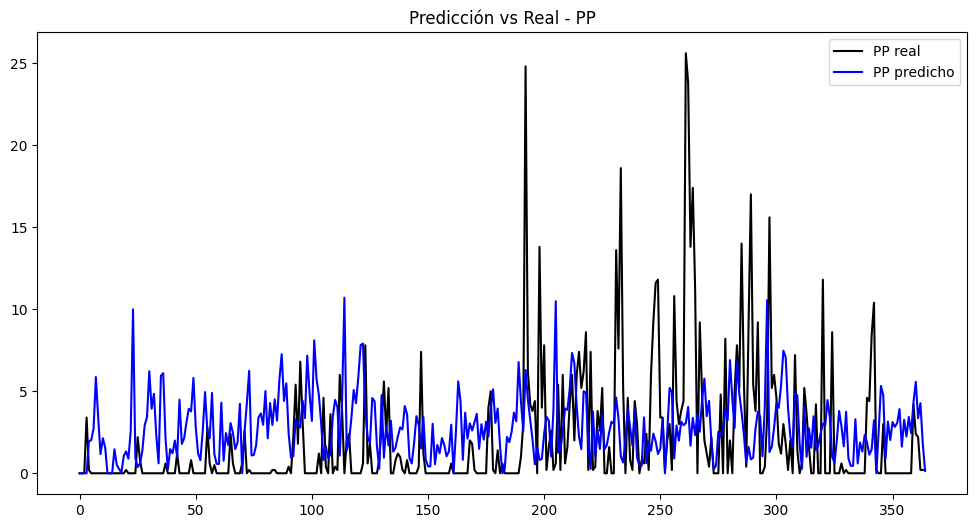

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['PP'], label='PP real', color='black')
plt.plot(df_resultado['PP_Pronosticado'], label='PP predicho', color='blue')
plt.title('Predicción vs Real - PP')
plt.legend()
plt.show()


## Visualización del Pronóstico a Futuro (91 pasos)

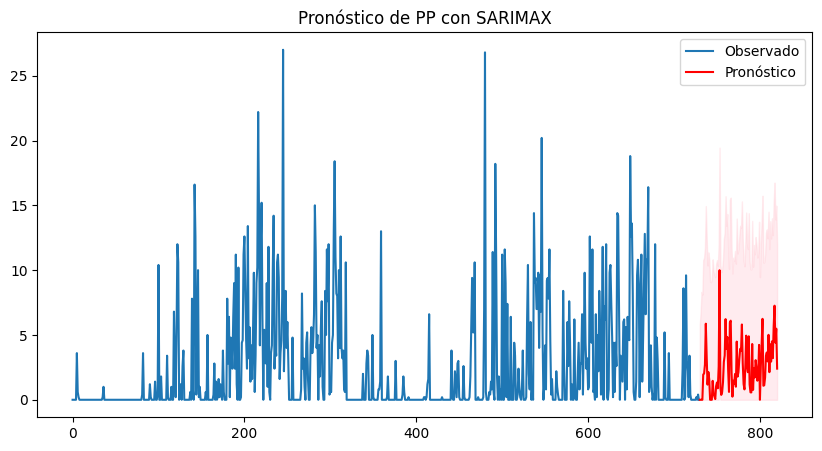

In [ ]:
import matplotlib.pyplot as plt

pred = results.get_forecast(steps=91)
conf_int = pred.conf_int()
conf_int.iloc[:, 0] = conf_int.iloc[:, 0].clip(lower=0)

plt.figure(figsize=(10,5))
plt.plot(df_train.index, df_train['PP'], label='Observado')
plt.plot(pred.predicted_mean.index, pred.predicted_mean.clip(lower=0), label='Pronóstico', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Pronóstico de PP con SARIMAX')
plt.show()


# Evaluación del Modelo

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = df_resultado['PP_Pronosticado']
y_true = df_test['PP']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

mean_real = y_true.mean()
mae_rel = mae / mean_real * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE Relativo: {mae_rel:.2f}%")

MAE: 3.08
RMSE: 4.33
R²: -0.25
MAE Relativo: 148.39%
